# Data exploration

In [1]:
import pandas as pd
from pathlib import Path
import os

import matplotlib.pyplot as plt
from skimage import io
import numpy as np

In [2]:
path: Path = Path("./data/")
train_path: Path = path / "train"
df = pd.read_csv(path / "answer.csv", names=["img_name", "mining"])
df.head()

,img_name,mining
0,train_0.tif,0
1,train_1.tif,0
2,train_2.tif,0
3,train_3.tif,1
4,train_4.tif,0


In [3]:
df.shape

(1242, 2)

In [4]:
(train_path / df.iloc[0]["img_name"]).exists()

True

In [5]:
img_tif = io.imread(train_path / df.iloc[0]["img_name"])
img = np.array(img_tif)

In [6]:
img.shape

(512, 512, 12)

Las bandas 4, 3 y 2 son las que corresponden a RGB, en ese orden.  
https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands

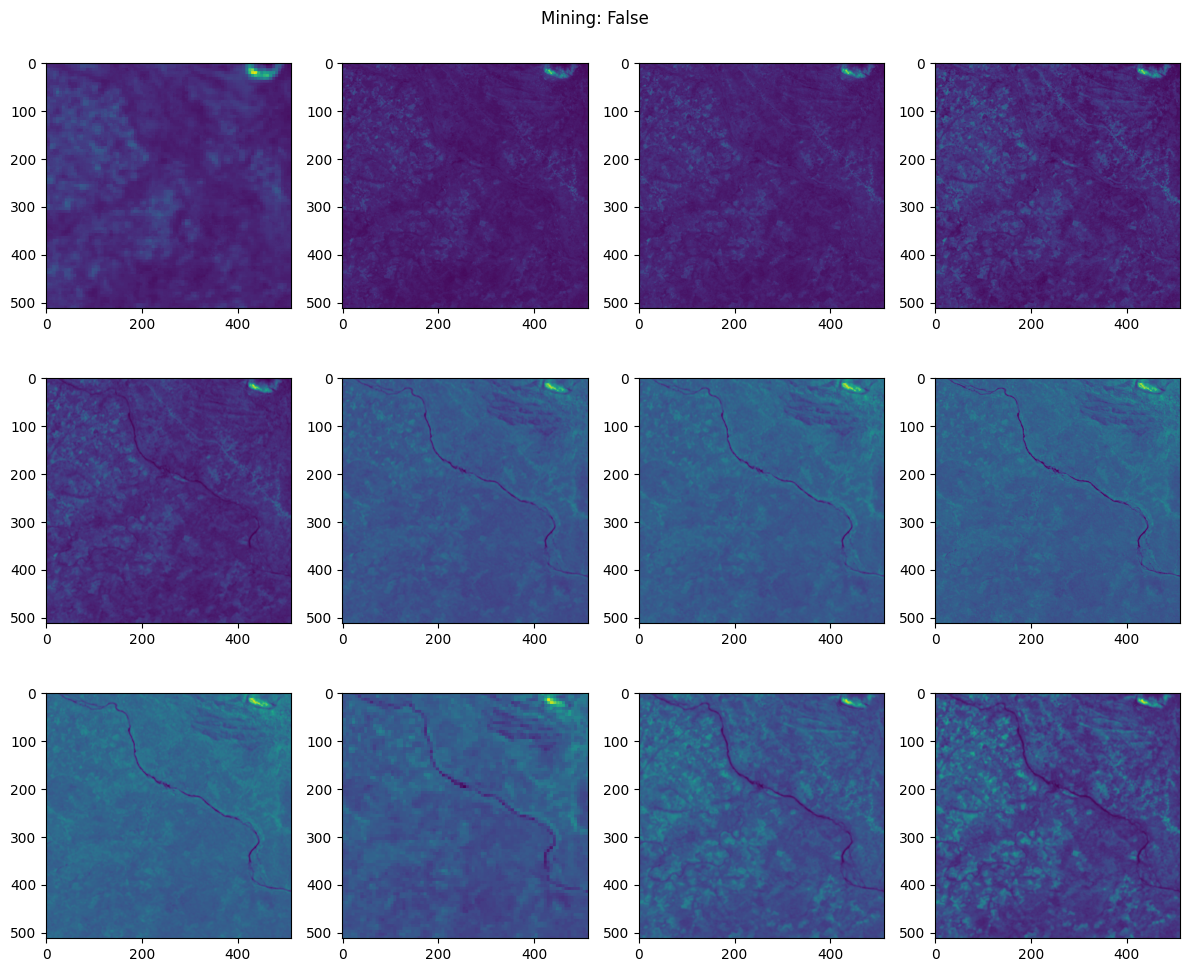

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,10))
axes = axes.flatten()
img = io.imread(train_path / df.iloc[0]["img_name"])
for i, ax in enumerate(axes):
    ax.imshow(img[:, :, i])
plt.suptitle(f"Mining: {True if df.iloc[0]['mining'] else False}")
plt.tight_layout()
plt.show()

In [8]:
r, g, b = img[:,:,3], img[:,:,2], img[:,:,1]
rgb = np.dstack((r,g,b))
# rgb = np.clip(rgb, 0, 1)

rgb.min(), rgb.max(), rgb.dtype

(0.02645, 0.498, dtype('float32'))

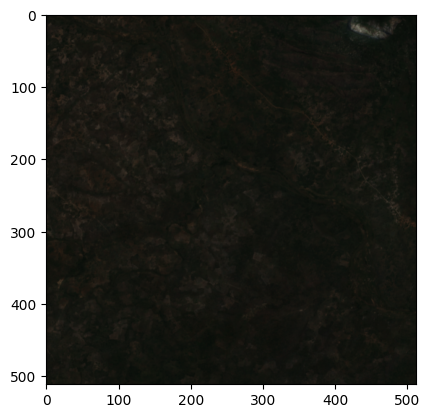

In [9]:
plt.imshow(rgb)

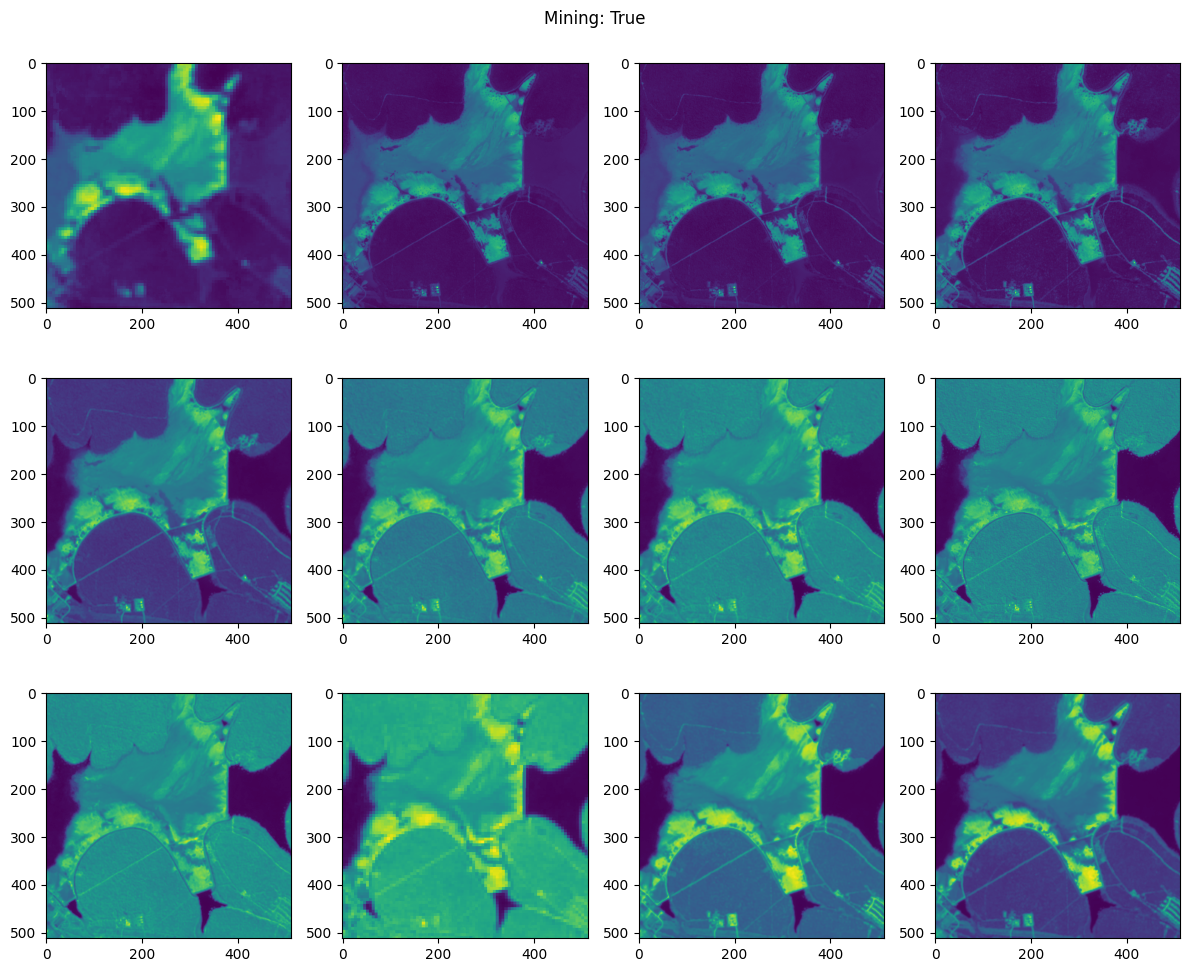

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,10))
axes = axes.flatten()
mining_imgs = df[df["mining"] == 1]
img = io.imread(train_path / mining_imgs.iloc[0]["img_name"])
for i, ax in enumerate(axes):
    ax.imshow(img[:, :, i])
plt.suptitle(f"Mining: {True if mining_imgs.iloc[0]['mining'] else False}")
plt.tight_layout()
plt.show()

In [11]:
r, g, b = img[:,:,3], img[:,:,2], img[:,:,1]
rgb = np.dstack((r,g,b))
# rgb = np.clip(rgb, 0, 1)

rgb.min(), rgb.max(), rgb.dtype

(0.026933333, 0.4112, dtype('float32'))

In [12]:
rgb = img[...,1:4][...,::-1]
rgb.shape

(512, 512, 3)

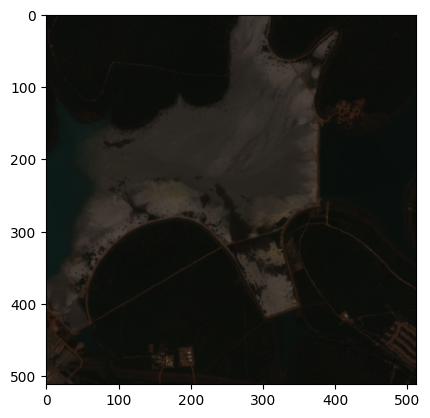

In [13]:
plt.imshow(rgb)

# Class balance

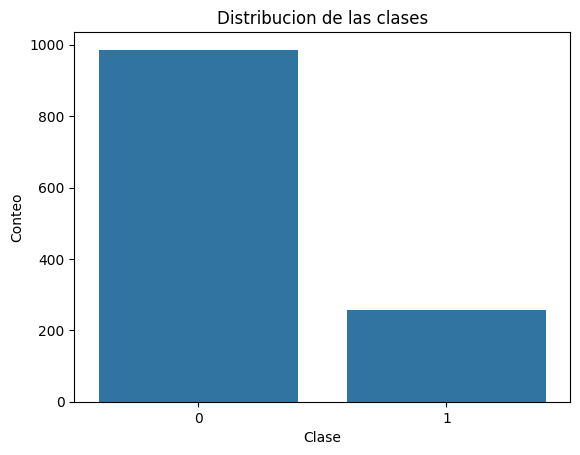

In [14]:
import seaborn as sns

sns.countplot(
    data=df,
    x="mining",
)

plt.title("Distribucion de las clases")
plt.xlabel("Clase")
plt.ylabel("Conteo")
plt.show()

In [15]:
df["mining"].value_counts(normalize=True)

mining
0    0.793881
1    0.206119
Name: proportion, dtype: float64

In [16]:
from pathlib import Path

import torch 
from skimage import io
import numpy as np
from torchvision.transforms import v2

train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomVerticalFlip(),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
])

test_transforms = v2.Compose([
    v2.Resize(256),
    v2.ToTensor(),
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, trans):
        self.images = images
        self.labels = labels
        self.trans = trans

        self.imgs_path = Path("./data/train/")

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = io.imread(self.imgs_path / self.images[index])
        label = self.labels[index]
        
        # Take RGB Channels
        # print(type(image))
        image = image[...,1:4][...,::-1]
        # print(type(image))

        if self.trans:
            image = self.trans(image.copy())
        else:
            image = torch.from_numpy(image).float().permute(2,0,1)

        return image, torch.tensor((label, )).float()

c:\Users\Guillermo\miniconda3\envs\cv\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["mining"]), df["mining"],
    stratify=df["mining"], random_state=11,
)

print(f"{X_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_train.shape = }")
print(f"{y_test.shape = }")

X_train.shape = (931, 1)
X_test.shape = (311, 1)
y_train.shape = (931,)
y_test.shape = (311,)


In [18]:
y_test

958     0
1028    0
1161    1
364     0
986     0
       ..
634     1
522     1
630     0
104     0
1170    0
Name: mining, Length: 311, dtype: int64

In [19]:
ds = {
    'train': Dataset(X_train['img_name'].values, y_train.values, trans=train_transforms),
    'val': Dataset(X_test['img_name'].values, y_test.values, trans=test_transforms),
}

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=4, shuffle=True),
    'val': torch.utils.data.DataLoader(ds['val'], batch_size=4, shuffle=False),
}

In [20]:
batch = next(iter(dl['train']))
images, labels = batch

images.shape, images.dtype, labels.shape, labels.dtype

(torch.Size([4, 3, 512, 512]),
 torch.float32,
 torch.Size([4, 1]),
 torch.float32)

In [21]:
len(df["mining"].unique())

2

In [51]:
import timm
import lightning as L
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import F1Score

MODEL_NAME = "resnet18"

class Module(L.LightningModule):
    def __init__(self):
        super().__init__()
        # self.model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=1)
        # self.model.conv1 = torch.nn.Conv2d(12, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
        self.model = torch.hub.load(
            'hankyul2/EfficientNetV2-pytorch', 'efficientnet_v2_s', 
            pretrained=False, nclass=1,
        )
        # self.model.stem[0] = torch.nn.Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()	
        # self.metric = lambda y_hat, y: torch.sum(torch.round(y_hat) == y).item() / y.shape[0]
        self.accuracy = BinaryAccuracy(threshold=0.5)
        self.f1 = F1Score(num_classes=1, task="binary")

        self.training_logs = {
            "train_loss" : [],
            "val_loss" : [],
            "train_f1" : [],
            "train_acc" : [],
            "val_acc" : [],
            "val_f1" : [],
        }

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-4)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y)
        f1 = self.f1(y_hat, y)
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        self.log('train_f1', f1, prog_bar=True)

        self.training_logs["train_loss"].append(loss)
        self.training_logs["train_acc"].append(acc)
        self.training_logs["train_f1"].append(f1)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y)
        f1 = self.f1(y_hat, y)
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)

        self.training_logs["val_loss"].append(loss)
        self.training_logs["val_acc"].append(acc)
        self.training_logs["val_f1"].append(f1)

In [52]:
# module = Module()
# out = module.model(torch.randn(16, 12, 512, 512))
# out.shape

In [53]:
# model = torch.hub.load('hankyul2/EfficientNetV2-pytorch', 'efficientnet_v2_s', pretrained=False, nclass=1)
# model.stem[0] = torch.nn.Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [54]:
# model.stem, labels.shape

In [55]:
# torch.nn.BCEWithLogitsLoss()(out, labels)

In [56]:
metric = lambda y_hat, y: torch.sum(torch.round(y_hat) == y).item() / y.shape[0]
metric = BinaryAccuracy()
y_hat = torch.tensor([0.7, 0.3, 0.2, 0.9])
y = torch.tensor([1, 0, 0, 1])
metric(y_hat, y)

tensor(1.)

In [57]:
# torch.set_float32_matmul_precision('high')

module = Module()

trainer = L.Trainer(
    accelerator="cuda",
    devices=1,
    max_epochs=10,
)

Using cache found in C:\Users\Guillermo/.cache\torch\hub\hankyul2_EfficientNetV2-pytorch_main
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [58]:
trainer.fit(module, dl['train'], dl['val'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name     | Type              | Params
-----------------------------------------------
0 | model    | EfficientNetV2    | 20.2 M
1 | loss_fn  | BCEWithLogitsLoss | 0     
2 | accuracy | BinaryAccuracy    | 0     
3 | f1       | BinaryF1Score     | 0     
-----------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.715    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Guillermo\miniconda3\envs\cv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\Guillermo\miniconda3\envs\cv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 233/233 [01:56<00:00,  2.00it/s, v_num=22, train_acc=1.000, train_f1=0.000, val_loss=0.607, val_acc=0.765, val_f1=0.118]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 233/233 [01:58<00:00,  1.97it/s, v_num=22, train_acc=1.000, train_f1=0.000, val_loss=0.607, val_acc=0.765, val_f1=0.118]


In [49]:
from torchinfo import summary

summary(module.model, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNetV2                                     [1, 1]                    --
├─ConvBNAct: 1-1                                   [1, 24, 256, 256]         --
│    └─Conv2d: 2-1                                 [1, 24, 256, 256]         648
│    └─BatchNorm2d: 2-2                            [1, 24, 256, 256]         48
│    └─SiLU: 2-3                                   [1, 24, 256, 256]         --
├─Sequential: 1-2                                  [1, 256, 16, 16]          --
│    └─MBConv: 2-4                                 [1, 24, 256, 256]         --
│    │    └─Sequential: 3-1                        [1, 24, 256, 256]         5,232
│    │    └─StochasticDepth: 3-2                   [1, 24, 256, 256]         --
│    └─MBConv: 2-5                                 [1, 24, 256, 256]         --
│    │    └─Sequential: 3-3                        [1, 24, 256, 256]         5,232
│    │    └─StochasticDepth: